# Image Classification - The Multi-class Weather Dataset

In this assignment we focus on an end-to-end image classification application. We will train and test the data using the Multi-class Weather Dataset (MWD):

- https://data.mendeley.com/datasets/4drtyfjtfy/1

The MWD contains labelled images representing various weather scenarios. It is a small and popular dataset for practice with image classification.

# Tasks
## Task 1 - Data exploration, preparation, and partition 

Download the MWD from this site and unzip it:

- https://data.mendeley.com/datasets/4drtyfjtfy/1

You will observe that the zipped file contains 1,125 images representing various weather conditions. To facilitate the assessment of this assignment, please make sure that the images are in a folder named `dataset2` and this folder is in the same place as this jupyter notebook.

### 1.1 - data partition 

Generate three CSV files named `my_training.csv`, `my_validation.csv`, and `my_test.csv` that partition the dataset into the training, validation, and test set. Each CSV file contains the following two fields:

- File path
- Image label

For example, the file `my_training.csv` could start like this:

```csv
dataset2/cloudy1.jpg,cloudy
dataset2/shine170.jpg,shine
dataset2/shine116.jpg,shine
```

Make sure that the partitions are created randomly, so that the label distribution is similar in each partition. Also, make sure that the samples are sorted in no particular order (randomly)

Display the label distribution of each partition, and display the first 10 rows of each partition.

The following sample files are available together with these instructions. Your files should look similar to these.

- `training.csv`
- `validation.csv`
- `test.csv`

**For the subsequent tasks in this assignment, use the files we provide (`training.csv`, `validation.csv`, `test.csv`). Do not use the files that you have generated, so that any errors generated by your solution do not carry to the rest of the assignment. Also, the files we provide conveniently removed references to images that have a number of channels different from 3.**




In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

2024-04-08 15:28:31.375216: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.16.1


In [2]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [3]:
import keras
keras.__version__

'3.1.1'

In [4]:
import numpy as np
import os 
import pandas as pd
from matplotlib import pyplot as plt
import glob
import unittest
import keras
import keras_tuner as kt
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [5]:
# List all image files and their labels
image_files = []
labels = []

for root, dirs, files in os.walk("dataset2"):
    for file in files:
        if file.endswith(".jpg"):
            image_files.append(os.path.join(root, file))
            labels.append(root.split("/")[-1])

# Combine image files and labels into a DataFrame
data = pd.DataFrame({
    "File path": image_files,
    "Image label": labels
})

# Shuffle the DataFrame
data = data.sample(frac=1).reset_index(drop=True)

# Partitioning the data into training, validation, and test sets
train_size = int(0.7 * len(data))
val_size = int(0.15 * len(data))
test_size = len(data) - train_size - val_size

my_training = data[:train_size]
my_validation = data[train_size:train_size + val_size]
my_test = data[train_size + val_size:]

# Save partitioned data to CSV files
my_training.to_csv("my_training.csv", index=False)
my_validation.to_csv("my_validation.csv", index=False)
my_test.to_csv("my_test.csv", index=False)

# Display label distribution and first 10 rows for each partition
print("Training data label distribution:")
print(my_training["Image label"].value_counts())
print("\nFirst 10 rows of training data:")
print(my_training.head(10))

print("\nValidation data label distribution:")
print(my_validation["Image label"].value_counts())
print("\nFirst 10 rows of validation data:")
print(my_validation.head(10))

print("\nTest data label distribution:")
print(my_test["Image label"].value_counts())
print("\nFirst 10 rows of test data:")
print(my_test.head(10))

Training data label distribution:
dataset2    785
Name: Image label, dtype: int64

First 10 rows of training data:
                 File path Image label
0     dataset2/shine44.jpg    dataset2
1  dataset2/sunrise312.jpg    dataset2
2   dataset2/sunrise52.jpg    dataset2
3    dataset2/shine158.jpg    dataset2
4   dataset2/sunrise35.jpg    dataset2
5   dataset2/sunrise24.jpg    dataset2
6  dataset2/sunrise352.jpg    dataset2
7  dataset2/sunrise121.jpg    dataset2
8  dataset2/sunrise226.jpg    dataset2
9     dataset2/shine16.jpg    dataset2

Validation data label distribution:
dataset2    168
Name: Image label, dtype: int64

First 10 rows of validation data:
                  File path Image label
785   dataset2/cloudy46.jpg    dataset2
786  dataset2/cloudy127.jpg    dataset2
787  dataset2/sunrise91.jpg    dataset2
788  dataset2/cloudy299.jpg    dataset2
789   dataset2/cloudy15.jpg    dataset2
790  dataset2/cloudy170.jpg    dataset2
791  dataset2/sunrise62.jpg    dataset2
792    dataset2/

### 1.2 - preprocessing and preparation

Use TensorFlow's `TextLineDataset` to generate datasets for training, validation, and test. The datasets need to produce images that are re-sized to dimensions 230 x 230 and 3 channels, and the values of the pixels must be normalised to the range [0, 1].


In [6]:
pd_train_set = pd.read_csv("training.csv", names=['path','weather'])
pd_train_set.head()

path  weather
0    dataset2/shine137.jpg    shine
1    dataset2/shine177.jpg    shine
2    dataset2/cloudy87.jpg   cloudy
3  dataset2/sunrise290.jpg  sunrise
4     dataset2/shine88.jpg    shine

In [7]:
CLASS_NAMES = pd_train_set["weather"].unique()
print("Class Names:", CLASS_NAMES)

Class Names: ['shine' 'cloudy' 'sunrise' 'rain']


In [8]:
IMG_HEIGHT = 230
IMG_WIDTH = 230
IMG_CHANNELS = 3
CLASS_NAMES = ["shine", "cloudy", "sunrise", "rain"]

In [9]:
# We redefine read_and_decode so that it uses TensorFlow's tensors
def read_and_decode(filename, reshape_dims):
  # Read the file
  img = tf.io.read_file(filename)
  # Convert the compressed string to a 3D uint8 tensor.
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # Resize the image to the desired size.
  return tf.image.resize(img, reshape_dims)

# decode_csv changed so that the label is the index into CLASS_NAMES array
def decode_csv(csv_row):
  record_defaults = ["path", "weather"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.math.equal(CLASS_NAMES, label_string)
  return img, label

train_dataset = (tf.data.TextLineDataset(
    "training.csv").
    map(decode_csv)).batch(32)

eval_dataset = (tf.data.TextLineDataset(
    "validation.csv").
    map(decode_csv)).batch(32)

test_dataset = (tf.data.TextLineDataset(
    "test.csv").
    map(decode_csv)).batch(32)

## Task 2 - A simple classifier 

### 2.1 First classifier 

Create a simple model that contains the following layers:

- A `Flatten` layer.
- The output layer with the correct size and activation function for this classification task.

Then, train the model with the training data. Use the validation data to determine when to stop training. Finally, test the trained model on the test data and report the accuracy.

In [10]:

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric], ls='dashed')
    ax[idx].set_xlabel("Epochs")
    ax[idx].set_ylabel(metric)
    ax[idx].plot(history.history['val_' + metric]);
    ax[idx].legend([metric, 'val_' + metric])

In [11]:
# linear model
def train_and_evaluate(batch_size = 32,
                       epochs = 10):
    
    model1 = keras.Sequential([
              keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              keras.layers.Dense(len(CLASS_NAMES), activation='softmax')
    ])

    model1.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    print(model1.summary())
    
    history = model1.fit(train_dataset, validation_data=eval_dataset, epochs=epochs,
                      callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)])  
    training_plot(['loss', 'accuracy'], history)
    return model1

/Applications/anaconda3/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 158700)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │       634,804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 634,804 (2.42 MB)

 Trainable params: 634,804 (2.42 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
     25/Unknown 4s 117ms/step - accuracy: 0.3377 - loss: 39.7334

2024-04-08 15:28:43.401440: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Applications/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - accuracy: 0.3410 - loss: 39.3608 - val_accuracy: 0.6407 - val_loss: 8.3330
Epoch 2/10
 1/25 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.8438 - loss: 2.9792

2024-04-08 15:28:44.722910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.6707 - loss: 9.6101

2024-04-08 15:28:47.918555: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.6712 - loss: 9.5299 - val_accuracy: 0.6407 - val_loss: 6.5839
Epoch 3/10
 1/25 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.7500 - loss: 3.7566

2024-04-08 15:28:49.182744: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.7186 - loss: 4.9409

2024-04-08 15:28:52.209579: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 171ms/step - accuracy: 0.7209 - loss: 4.8994 - val_accuracy: 0.7605 - val_loss: 2.4900
Epoch 4/10


2024-04-08 15:28:53.450135: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7566 - loss: 3.0725

2024-04-08 15:28:57.547880: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - accuracy: 0.7558 - loss: 3.0915 - val_accuracy: 0.6766 - val_loss: 5.6073
Epoch 5/10
 1/25 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - accuracy: 0.6562 - loss: 5.4261

2024-04-08 15:28:58.816691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7120 - loss: 4.3070

2024-04-08 15:29:02.008306: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 173ms/step - accuracy: 0.7118 - loss: 4.3144 - val_accuracy: 0.7425 - val_loss: 2.9122


2024-04-08 15:29:03.151472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


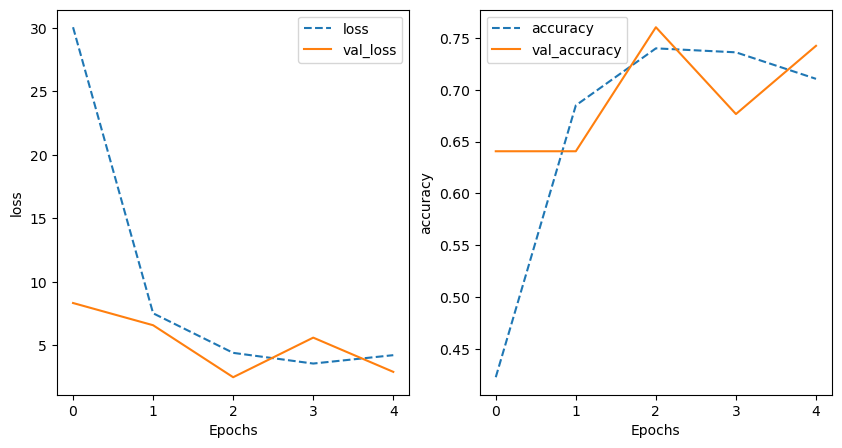

In [12]:
model1 = train_and_evaluate()

In the first epoch, the training and validation loss are high and the accuracy is relatively low. 

During the training progress, the loss declines and the accuracy increases for both the training and validation sets. However, there are fluctuations in the performance, where the validation loss increases again and the accuracy decreases.

The model is not yet achieving the desired accuracy level, which means there is room for further optimization and training.

#### Test the trained model on the test data:

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


2024-04-08 15:29:04.829493: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


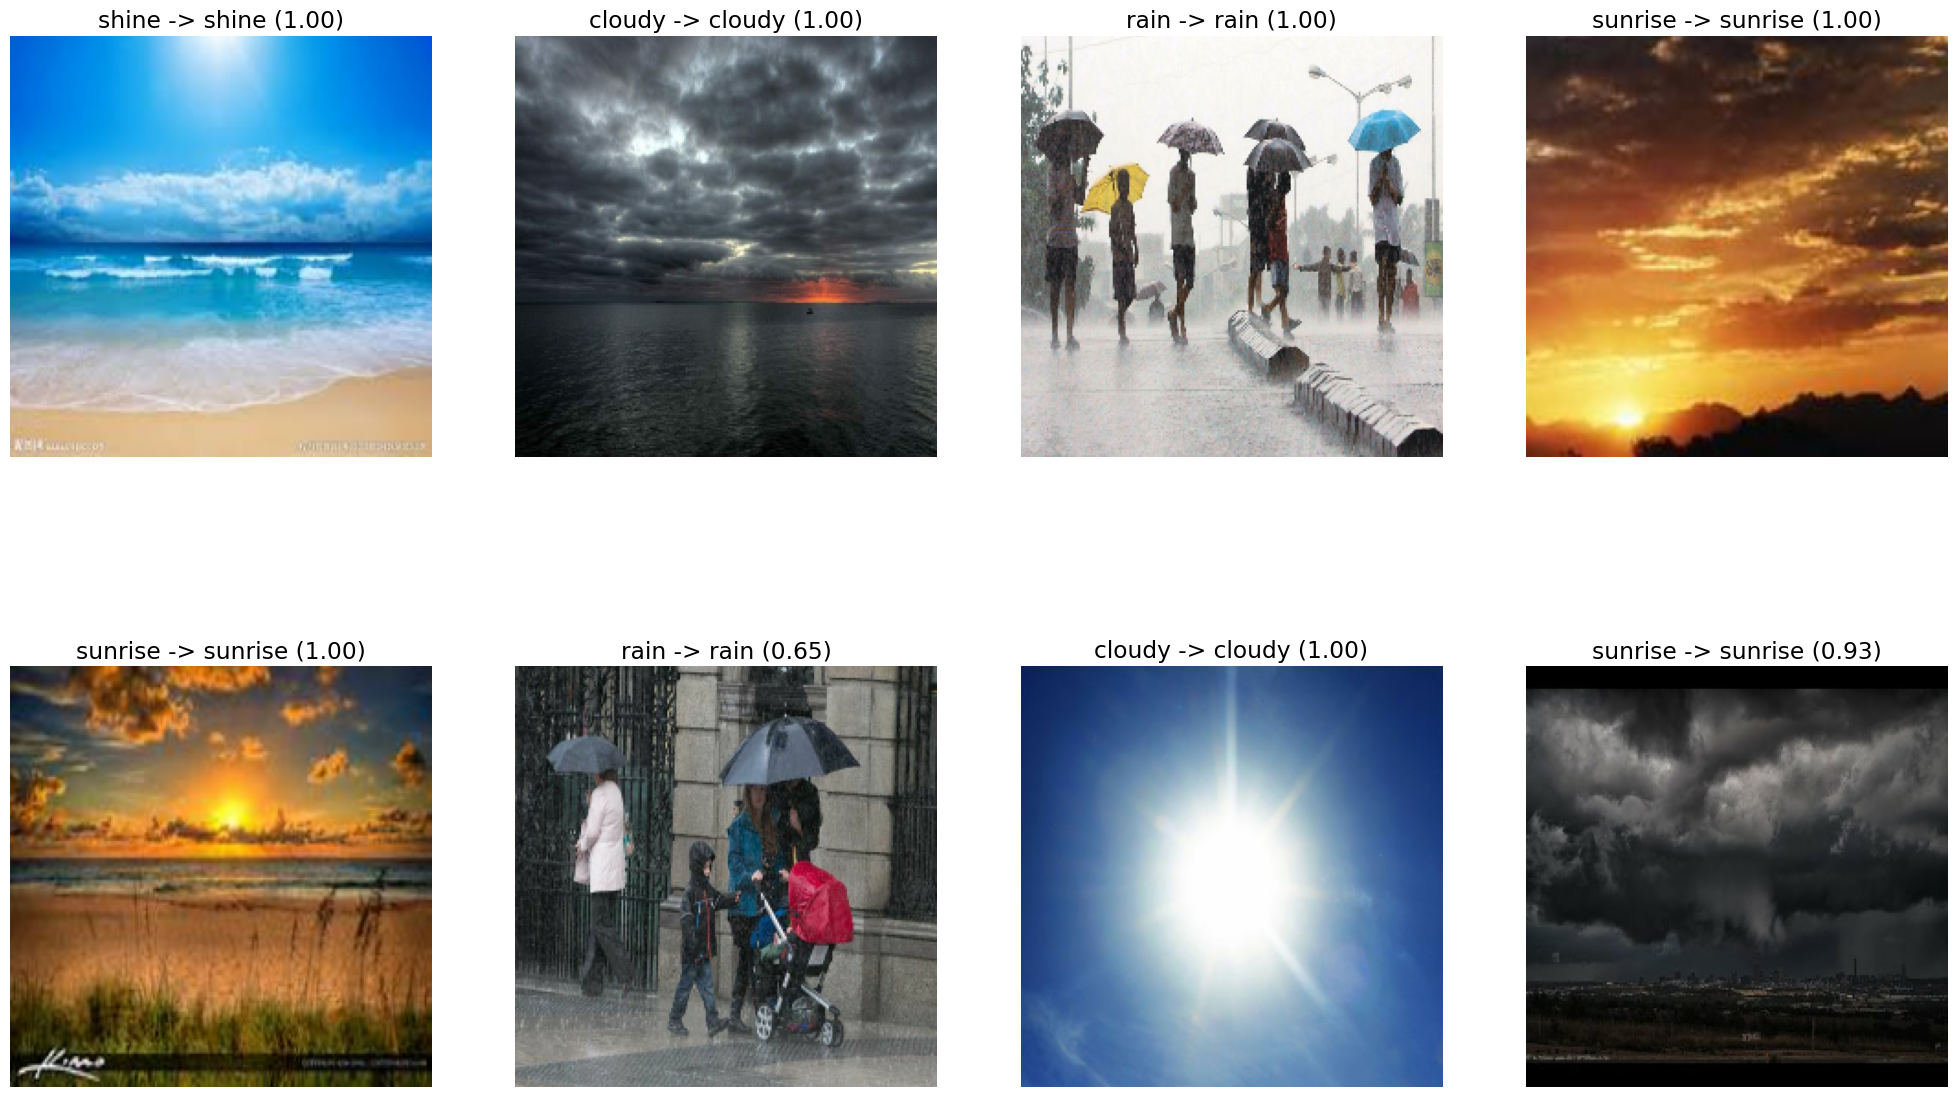

In [13]:
import matplotlib.pyplot as plt  
import matplotlib

def plot_predictions(filename, model1):
  matplotlib.rcParams.update({'font.size': 14})
  f, ax = plt.subplots(2, 4, figsize=(25,15))
  dataset = (tf.data.TextLineDataset(filename).
      map(decode_csv))
  for idx, (img, label) in enumerate(dataset.take(8)):
    ax[idx//4, idx%4].imshow((img.numpy()));
    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model1.predict(batch_image)
    pred = batch_pred[0]
    label_index = tf.math.argmax(pred).numpy()
    label = CLASS_NAMES[label_index]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]
    ax[idx//4, idx%4].set_title('{} -> {} ({:.2f})'.format(label, pred_label, prob))
    ax[idx//4, idx%4].axis('off')

plot_predictions("validation.csv", model1)

The predictions with the validation dataset are fairly accurate, most of the weather predictions match the actual weather conditions depicted in the photos.

### 2.2 A more complex classifier

We try a more complex architecture that has 1 or more hidden layers with dropout. For this more complex architecture, use `keras-tuner` and run it with a reasonable choice of possible parameters. We may try among the following:

- Number of hidden layers
- Sizes of hidden layers
- Dropout rate
- Learning rate

In [14]:
def build_model(hp):
  lrate = hp.Float('lrate', 1e-3, 1e-1, sampling='log')
  num_hidden = hp.Int('num_hidden', 32, 256, 32)
  dropout_rate = hp.Float('dropout', 0.0, 0.9)

  # NN with one hidden layes
  model2 = keras.Sequential([
              keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)),
              keras.layers.Dense(num_hidden,
                                    activation=keras.activations.relu),
              keras.layers.Dropout(dropout_rate),
              keras.layers.Dense(len(CLASS_NAMES),
                                    activation='softmax')
  ])
  model2.compile(optimizer=keras.optimizers.Adam(learning_rate=lrate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    
  return model2


tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=9,
    num_initial_points=2,
    overwrite=True) 

tuner.search(
    train_dataset, validation_data=eval_dataset,
    epochs=10,
    callbacks=[keras.callbacks.EarlyStopping(patience=2)]
)

topN = 1
for x in range(topN):
  print(tuner.get_best_hyperparameters(topN)[x].values)
  print(tuner.get_best_models(topN)[x].summary())

Trial 9 Complete [00h 00m 18s]
val_accuracy: 0.3053892254829407

Best val_accuracy So Far: 0.7604790329933167
Total elapsed time: 00h 08m 45s
{'lrate': 0.006747179148712341, 'num_hidden': 96, 'dropout': 0.0}


/Applications/anaconda3/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 158700)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 96)             │    15,235,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           388 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,235,684 (58.12 MB)

 Trainable params: 15,235,684 (58.12 MB)

 Non-trainable params: 0 (0.00 B)

None


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


2024-04-08 15:37:53.204901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


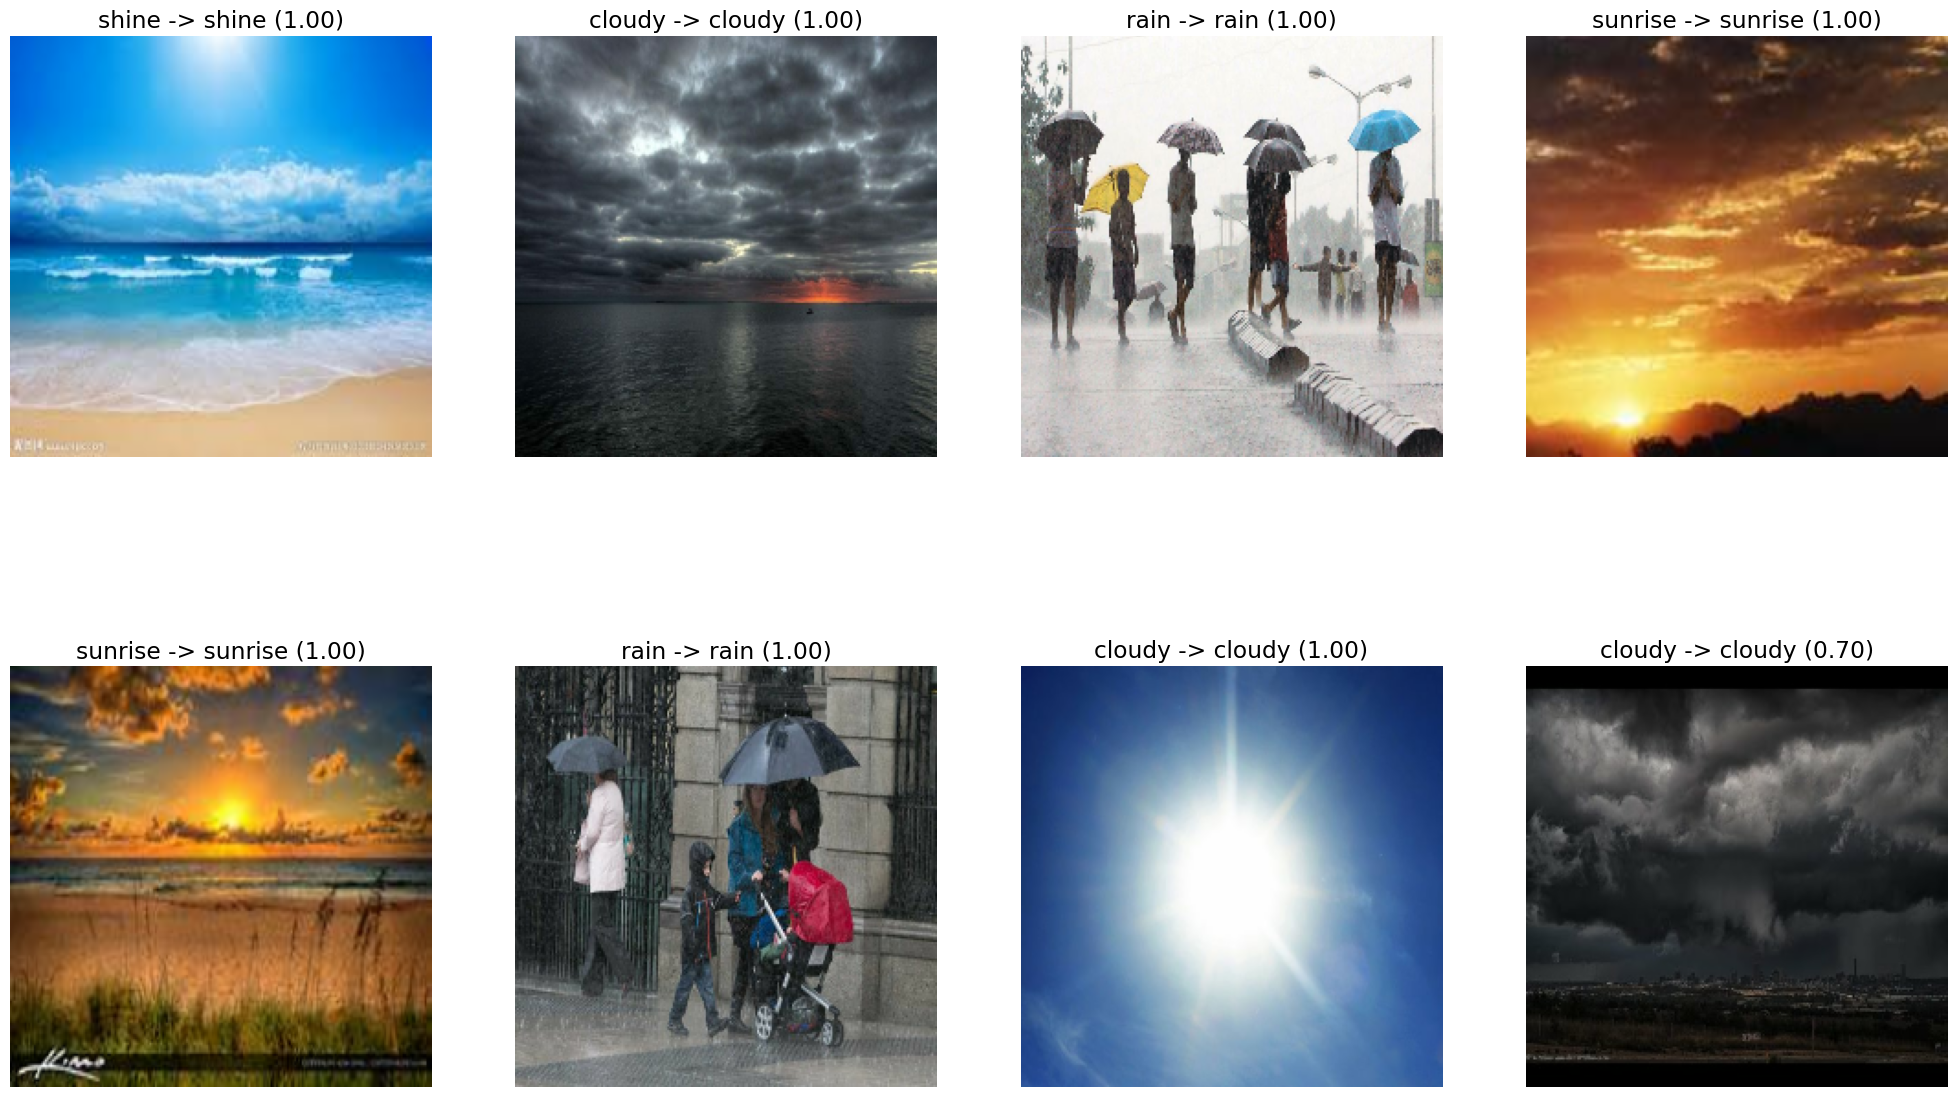

In [15]:
plot_predictions("validation.csv", tuner.get_best_models(1)[0])

- When we apply keras-tuner and run it with the key parameters such as number of hidden layers, sizes of hidden layers, dropout rate and learning rate, we can see that the model performance has been improved. 
- For example, the learning rate allows the tuner to explore both low and high learning rates, which are essential for training deep neural networks effectively. 
- We varied the number of hidden units in the single hidden layer between 32 to 256 with a step size of 32. This range provides flexibility to the tuner.
- Dropout is a regularization technique used to prevent overfitting. We allowed the dropout rate to vary between 0.0 to 0.9, providing the flexibility in regularizing the model.

### 2.3 Error analysis
Evaluate your best-performing system from task 2 against the system of task 1 and answer the following questions.

1. Which system had a better accuracy on the test data?
2. Which system had a lower degree of overfitting?

In [16]:
# Evaluate Model 1 on the test dataset
model1_test_accuracy = model1.evaluate(test_dataset)

# Evaluate Model 2 on the test dataset
model2_test_accuracy = tuner.get_best_models(1)[0].evaluate(test_dataset)

# Print the test accuracy of both models
print("Test Accuracy of Model 1:", model1_test_accuracy)
print("Test Accuracy of Model 2:", model2_test_accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 0.7182 - loss: 3.6850


2024-04-08 15:37:55.872742: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - accuracy: 0.7960 - loss: 2.3422
Test Accuracy of Model 1: [3.127211093902588, 0.7218934893608093]
Test Accuracy of Model 2: [1.8696404695510864, 0.8106508851051331]


2024-04-08 15:37:57.308883: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


System 1:
- Training Accuracy: 71.18%
- Validation Accuracy: 74.25%
- Test Accuracy: 72.19%

System 2:
- Validation Accuracy: 76.05%
- Test Accuracy: 81.07%

##### 1. Which system had a better accuracy on the test data?
Based on the model performance on test dataset above, System 2 had a higher accuracy on the test data.

##### 2. Which system had a lower degree of overfitting?
In System 1, the validation accuracy is slightly higher than the training accuracy, indicating that the model is not heavily overfitting to the training data. However, the test accuracy is slightly lower than the validation accuracy, suggesting a mild degree of overfitting.

In System 2, the test accuracy is notably higher than the validation accuracy, which could be a sign of overfitting.

Therefore, System 1 has a lower degree of overfitting compared to System 2.

## Task 3 - A more complex classifier

### Task 3.1 Using ConvNets 

Implement a model that uses a sequence of at least two `ConvD`, each one followed with `MaxPooling2D`. Use reasonable numbers for the hyperparameters (number of filters, kernel size, pool size, activation, etc). Feel free to research the internet and / or generative AI to help us find a reasonable choice of hyperparameters. For this task, do not use pre-trained models.

In [17]:
from keras import models, layers 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [18]:
model3 = models.Sequential()
model3.add(layers.Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)))
model3.add(layers.MaxPooling2D(pool_size=2)) 
model3.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu")) 
model3.add(layers.MaxPooling2D(pool_size=2)) 
model3.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu")) 
model3.add(layers.Flatten())
model3.add(layers.Dense(4, activation="softmax"))
model3.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

/Applications/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [19]:
model3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 228, 228, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 114, 114, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 54, 54, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 373248)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │     1,492,996 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,586,244 (6.05 MB)

 Trainable params: 1,586,244 (6.05 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train model:
history =  model3.fit(train_dataset, validation_data=eval_dataset, epochs=10,
                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])

Epoch 1/10
     25/Unknown 59s 2s/step - accuracy: 0.5026 - loss: 2.2792

2024-04-08 15:38:56.441066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5068 - loss: 2.2404 - val_accuracy: 0.7844 - val_loss: 0.6097
Epoch 2/10


2024-04-08 15:39:00.967795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8071 - loss: 0.5470

2024-04-08 15:39:55.500283: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.8074 - loss: 0.5447 - val_accuracy: 0.7904 - val_loss: 0.6045
Epoch 3/10


2024-04-08 15:39:59.701859: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8202 - loss: 0.4539

2024-04-08 15:40:52.940798: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/step - accuracy: 0.8209 - loss: 0.4520 - val_accuracy: 0.7964 - val_loss: 0.5128
Epoch 4/10


2024-04-08 15:40:57.187591: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8576 - loss: 0.3825

2024-04-08 15:41:52.691031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 61s 2s/step - accuracy: 0.8586 - loss: 0.3796 - val_accuracy: 0.7844 - val_loss: 0.6048


2024-04-08 15:41:57.704109: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


2024-04-08 15:42:15.044655: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


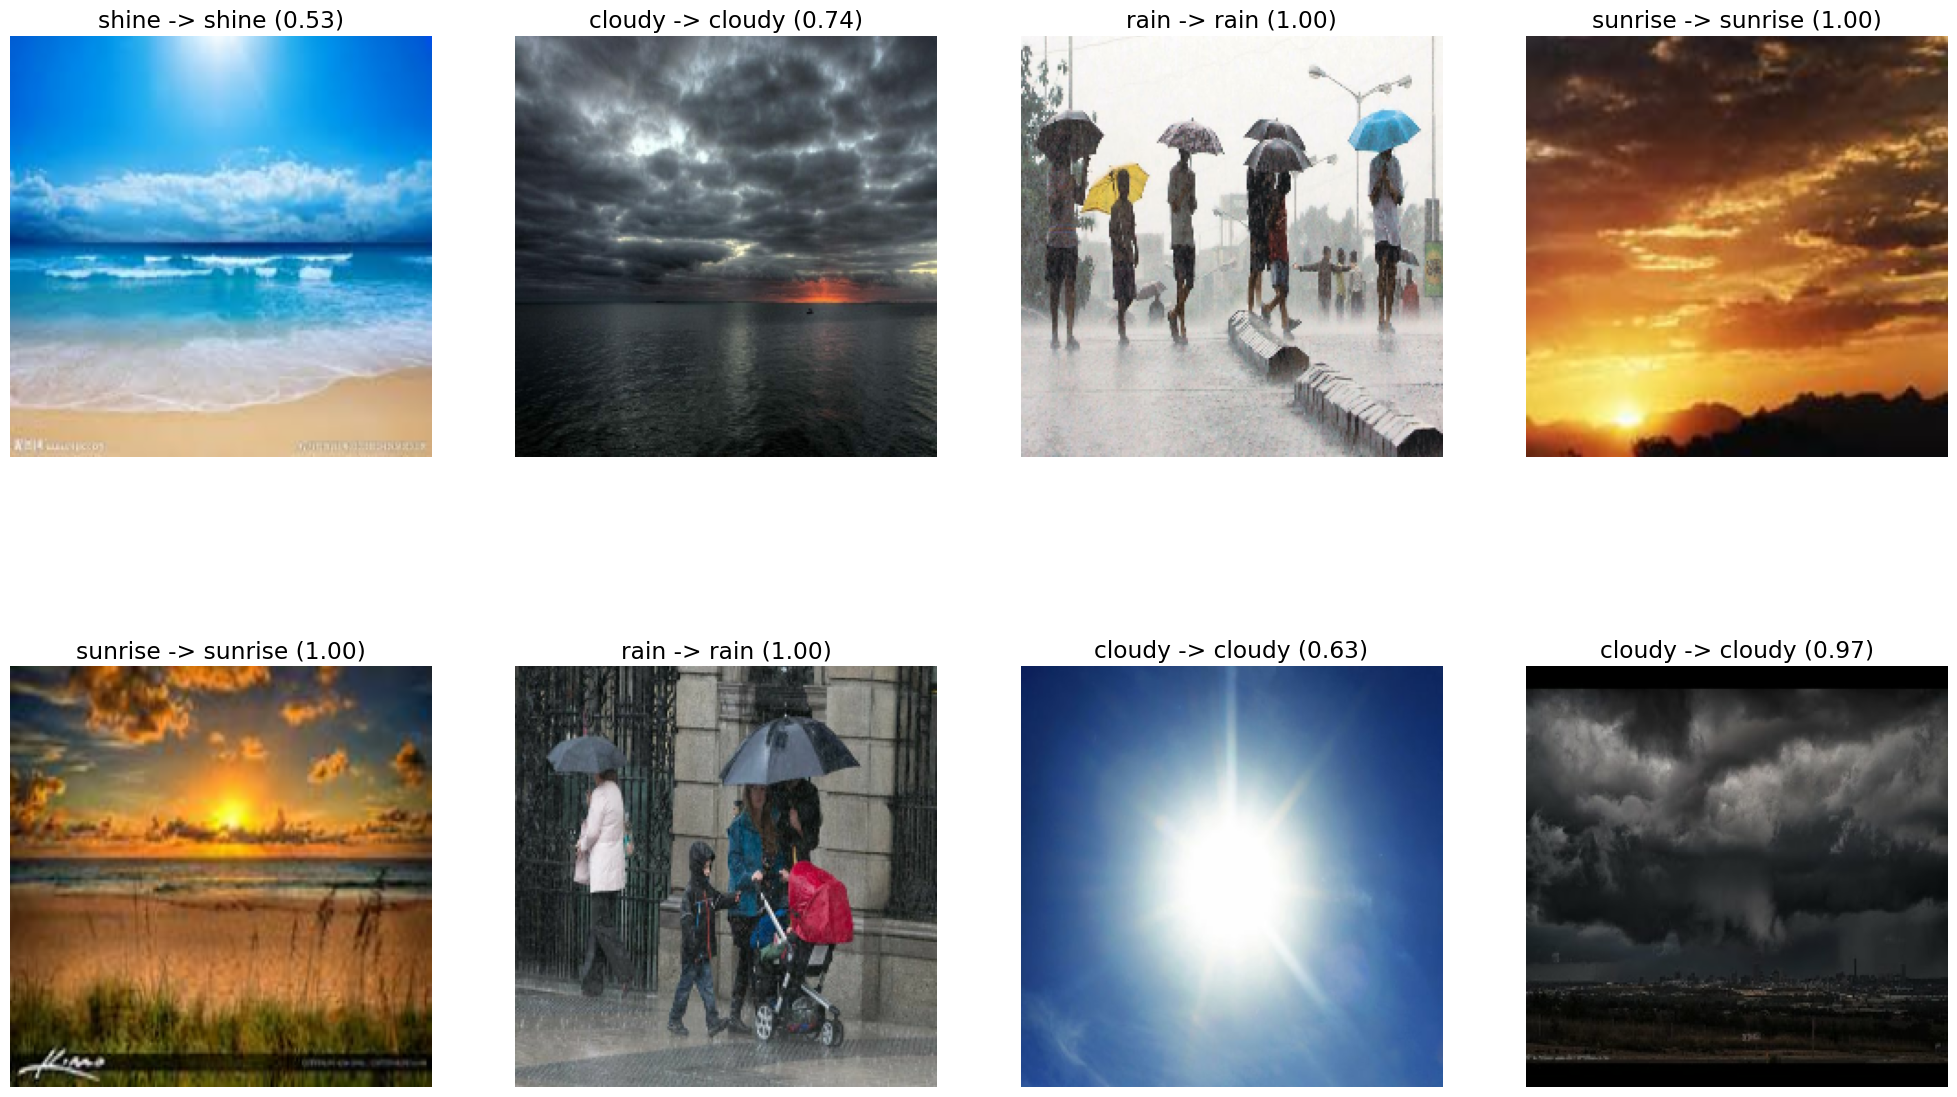

In [26]:
plot_predictions("validation.csv", model3)

The predictions with the validation dataset are highly accurate, totally match the actual weather conditions depicted in the photos.

### Task 3.2 Using pre-trained models

Use MobileNet, pre-trained on imagenet. Add the correct classification layer, and train it with your data. Make sure that we freeze MobileNet's weights during training. Also, make sure we use a reasonable schedule for the learning rate.

In [31]:
import tensorflow_hub as hub
import os
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [32]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.2),
    ]
)

In [33]:
# parameterize to the values in the previous cell
def train_and_evaluate(batch_size = 32,
                       lrate = 0.001,
                       num_hidden = 16,
                       epochs = 10):

    model4 = tf.keras.Sequential(name='weather_classification')
    model4.add(tf.keras.Input(shape=(230, 230, 3)))
    model4.add(tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (224, 224)), name='resize_layer'))
    model4.add(data_augmentation) 
    model4.add(tf.keras.layers.Lambda(lambda x: hub.KerasLayer(
            "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
            input_shape=(224, 224, 3),
            trainable=False)(x),
            name='mobilenet_embedding'))
    model4.add(tf.keras.layers.Dense(num_hidden,
                              activation='relu',
                              name='dense_hidden'))
    model4.add(tf.keras.layers.Dense(len(CLASS_NAMES),
                              activation='softmax',
                              name='weather_prob'))

    model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lrate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(model4.summary())

    history = model4.fit(train_dataset, validation_data=eval_dataset, epochs=epochs,
                        callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)])

    training_plot(['loss', 'accuracy'], history)

    return model4

Model: "weather_classification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resize_layer (Lambda)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_4 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_embedding (Lambda)    │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_hidden (Dense)            │ (None, 16)             │        20,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ weather_prob (Dense)            │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,564 (80.33 KB)

 Trainable params: 20,564 (80.33 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
     25/Unknown 35s 1s/step - accuracy: 0.5277 - loss: 1.0816

2024-04-08 15:50:10.638696: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5339 - loss: 1.0684 - val_accuracy: 0.8743 - val_loss: 0.3484
Epoch 2/10


2024-04-08 15:50:17.280518: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8995 - loss: 0.2949

2024-04-08 15:50:45.114251: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.8999 - loss: 0.2933 - val_accuracy: 0.9222 - val_loss: 0.2227
Epoch 3/10


2024-04-08 15:50:50.290825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9409 - loss: 0.1685

2024-04-08 15:51:18.632264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9412 - loss: 0.1680 - val_accuracy: 0.9341 - val_loss: 0.1590
Epoch 4/10


2024-04-08 15:51:24.286210: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9634 - loss: 0.1336

2024-04-08 15:51:52.975218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9634 - loss: 0.1332 - val_accuracy: 0.9401 - val_loss: 0.1391
Epoch 5/10


2024-04-08 15:51:59.065177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9577 - loss: 0.1116

2024-04-08 15:52:27.861234: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9578 - loss: 0.1117 - val_accuracy: 0.9401 - val_loss: 0.1201
Epoch 6/10


2024-04-08 15:52:33.125080: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9692 - loss: 0.1066

2024-04-08 15:53:02.079095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9693 - loss: 0.1059 - val_accuracy: 0.9162 - val_loss: 0.1282
Epoch 7/10


2024-04-08 15:53:07.255819: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9650 - loss: 0.1055

2024-04-08 15:53:36.500900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9649 - loss: 0.1055 - val_accuracy: 0.9461 - val_loss: 0.1043
Epoch 8/10


2024-04-08 15:53:41.839731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9872 - loss: 0.0622

2024-04-08 15:54:11.197404: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.9871 - loss: 0.0623 - val_accuracy: 0.9461 - val_loss: 0.1157
Epoch 9/10


2024-04-08 15:54:16.351304: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9801 - loss: 0.0823

2024-04-08 15:54:44.901050: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.9803 - loss: 0.0816 - val_accuracy: 0.9521 - val_loss: 0.1213


2024-04-08 15:54:50.413675: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


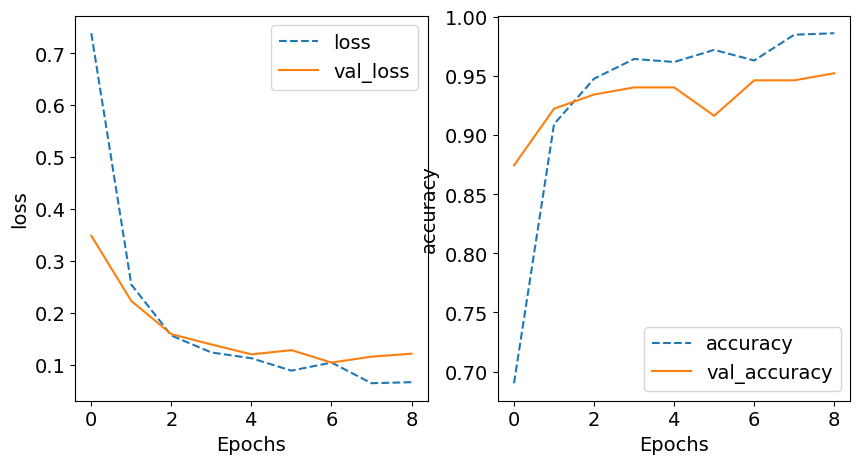

In [34]:
model4 = train_and_evaluate()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


2024-04-08 15:54:54.459341: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


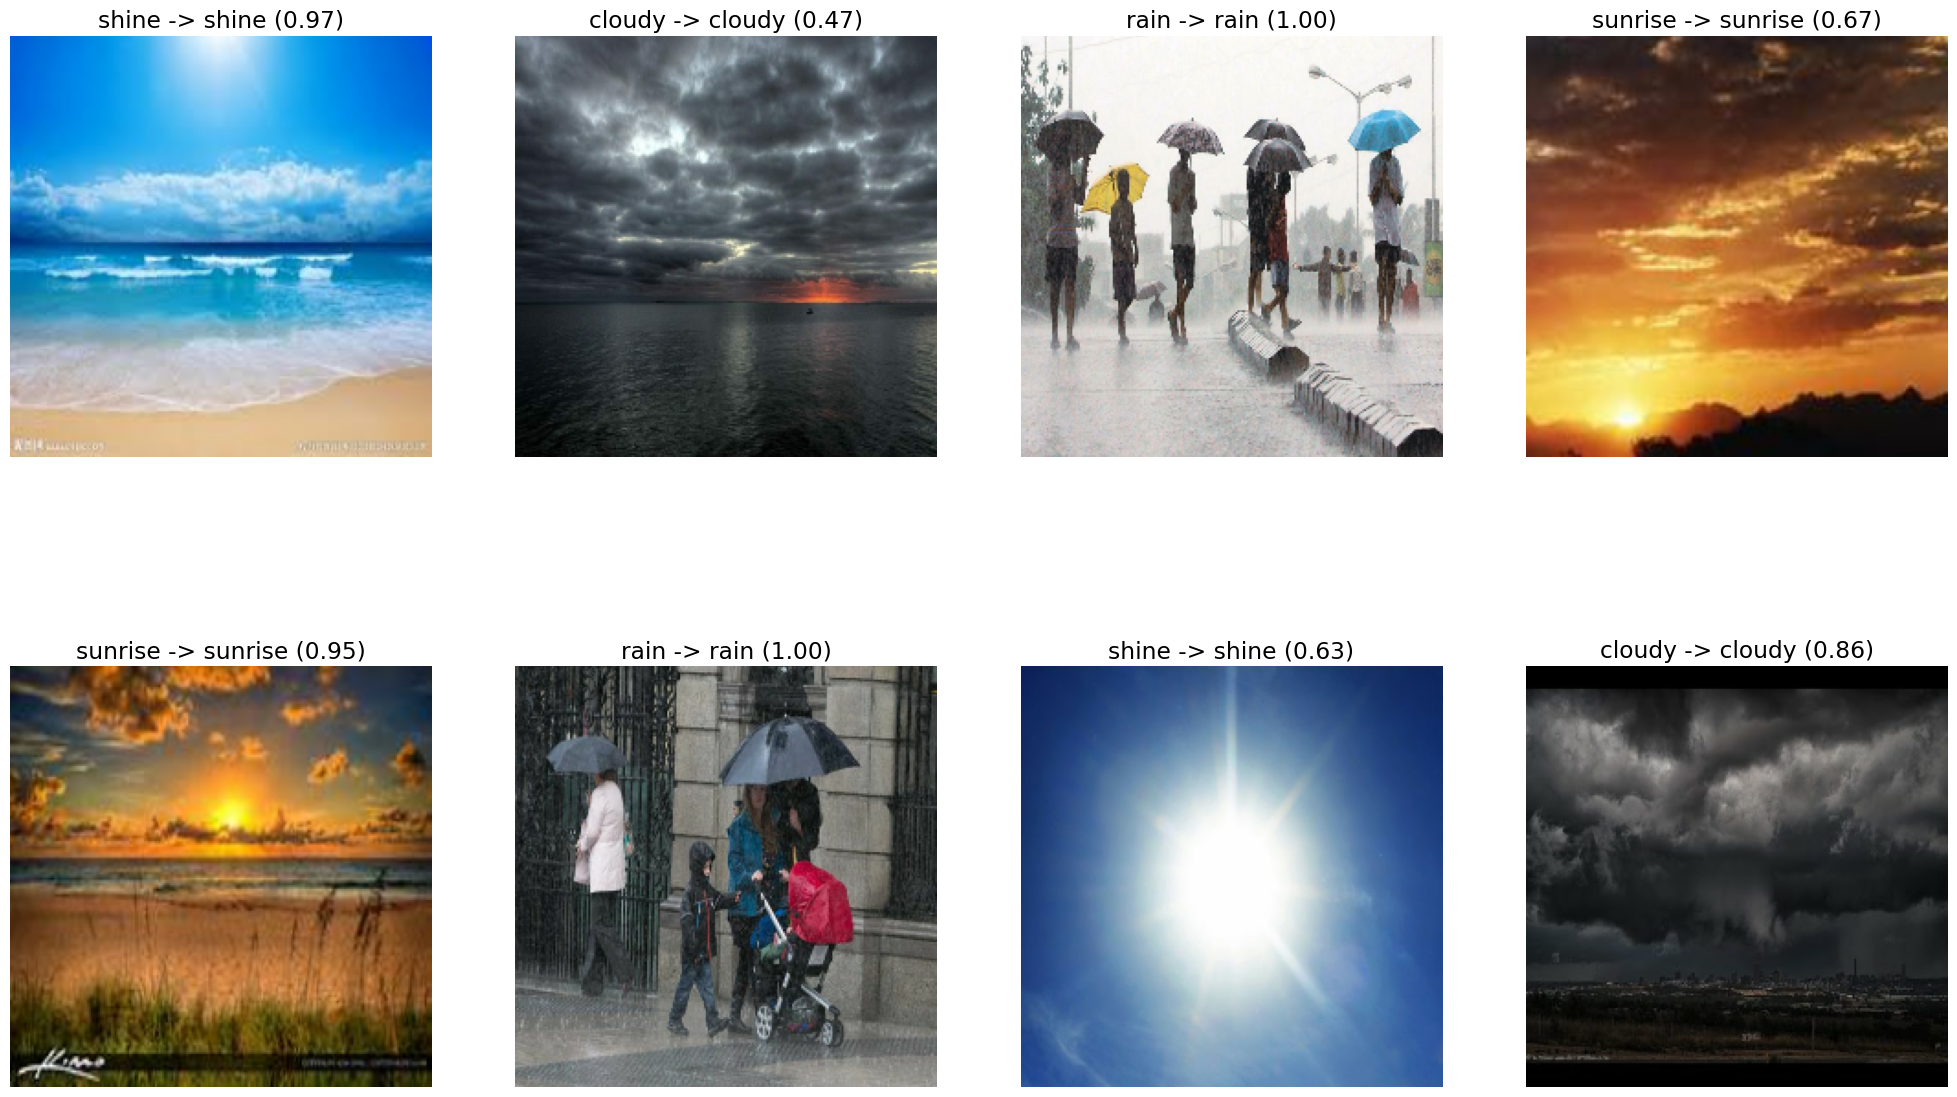

In [35]:
plot_predictions("validation.csv", model4)

### Task 3.3 Comparative evaluation

##### 1. Comparison of systems' performances (including the systems you developed in Task 2) and identify the best performer on the test set:

In [45]:
# Evaluate Model 3 (from task 3.1) on the test dataset
model3_test_accuracy = model3.evaluate(test_dataset)

# Evaluate Model 4 (from task 3.2) on the test dataset
model4_test_accuracy = model4.evaluate(test_dataset)

# Print the test accuracy of both models
print("Test Loss, Accuracy of Model 3:", model3_test_accuracy)
print("Test Loss, Accuracy of Model 4:", model4_test_accuracy)

6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 480ms/step - accuracy: 0.7377 - loss: 0.6175


2024-04-08 16:25:02.432293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 654ms/step - accuracy: 0.9607 - loss: 0.0865
Test Loss, Accuracy of Model 3: [0.4527679979801178, 0.7751479148864746]
Test Loss, Accuracy of Model 4: [0.06077555939555168, 0.9704142212867737]


2024-04-08 16:25:06.704967: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


We can have an overall review of the performance of all models as below:

System 1:
- Training Accuracy: 71.18%
- Validation Accuracy: 74.25%
- Test Accuracy: 72.19%

System 2:
- Validation Accuracy: 76.05%
- Test Accuracy: 81.07%

Sytem from Task 3.1 (Model 3):
- Training Accuracy: 85.86%
- Validation Accuracy: 78.44%
- Test Accuracy: 77.51%

Sytem from Task 3.2 (Model 4):
- Training Accuracy: 98.03%
- Validation Accuracy: 95.21%
- Test Accuracy: 97.04%

Based on the performance of all models above, we see that Model 4 (system from Task 3.2) has the highest test accuracy of 97.04%, making it the best-performing system on the test set among the ones listed. 

#####  2. The accuracy of the best system on each of weather categories, and identify the most difficult weather category to detect:

In [ ]:
import matplotlib.pyplot as plt

In [69]:
CLASS_NAMES = ["shine", "cloudy", "sunrise", "rain"]

# Initialize lists to store accuracies for each category
category_accuracies = {category: [] for category in CLASS_NAMES}

# Loop through the test dataset and calculate accuracy for each category
for x_batch, y_batch in test_dataset:
    predictions = model4.predict(x_batch)
    predicted_labels = np.argmax(predictions, axis=1)
    correct_predictions = np.argmax(y_batch, axis=1)
    for i, category in enumerate(CLASS_NAMES):
        category_indices = np.where(correct_predictions == i)[0]
        category_predictions = predicted_labels[category_indices]
        accuracy = np.mean(category_predictions == i)
        category_accuracies[category].append(accuracy)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 939ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 957ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 726ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step


2024-04-08 16:53:40.029773: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


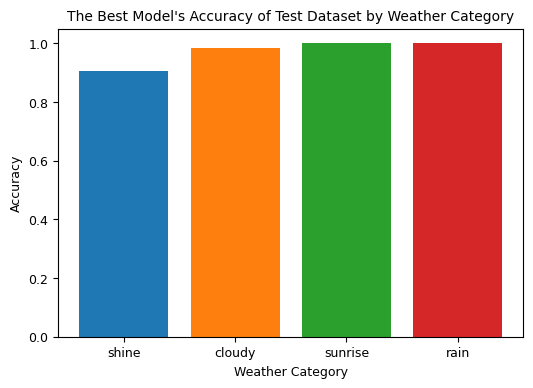

In [74]:
# Plot accuracies for each category
plt.figure(figsize=(6, 4))
for category, accuracies in category_accuracies.items():
    plt.bar(category, np.mean(accuracies))

plt.title("The Best Model's Accuracy of Test Dataset by Weather Category", fontsize=10)  
plt.xlabel('Weather Category', fontsize=9)  
plt.ylabel('Accuracy', fontsize=9)  
plt.xticks(fontsize=9)  
plt.yticks(fontsize=9)  
plt.show()

From the chart displayed above, we can notice that prediction of the 'shine' weather category in test dataset is the most difficulty compared to other categories.